# EDA

In [1]:
!pip install pymysql
!pip install meteostat
!pip install SQLAlchemy==1.4.48

In [2]:
import pandas as pd
import numpy as np

import datetime

from meteostat import Point, Daily
import sqlalchemy as sa

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno

******

************

## 1. Consulta a la base de datos

In [ ]:
class DatabaseConnection:

    # Información necesaria para establecer la conexión a la BBDD
    def __init__(self, password,
                 dialect = "mysql",
                 driver = "pymysql",
                 username = "xxx",
                 host = "xxx",
                 port = "3306",
                 database = "xxx")

        self.__password = password
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    # Función cuyo cometido es consultar una query a la BBDD y devolverla como un dataframe de Pandas
    def query_to_df(self, query):
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn.connection)
            return df


# Query a consultar. Cambio de nombre de fechaVenta.
# IMP: se omiten las columnas irrelevantes -> 'in_fecha_estudio' y 'tipo'
query_daily_and_top = """
SELECT familia,
articulo,
fechaVenta AS fecha_venta,
festivo,
precio,
cantidad,
importe,
orden_articulo_familia

FROM data.ventas_diarias_estudio
"""

# Instaciar la clase con la contraseña de la BBDD
database = DatabaseConnection("C0d35p4ce.")

# Consultar la query anterior y devolverla como un dataframe de Pandas
ventas = database.query_to_df(query_daily_and_top)

# Convertir 'fecha_venta' a un formato de fecha y 'articulo' a entero
ventas = (
           ventas.assign(fecha_venta = pd.to_datetime(ventas["fecha_venta"]))
                 .astype({"articulo": int})
        )

ventas

familia  articulo fecha_venta           festivo     precio  \
0        BOLLERIA      3960  2021-05-18              None   2.318000   
1        BOLLERIA      6286  2021-08-29              None   3.136000   
2        BOLLERIA      3880  2021-09-21              None   3.000000   
3        BOLLERIA      5803  2021-10-21              None   3.000000   
4        BOLLERIA      3880  2021-12-07              None   3.000000   
...           ...       ...         ...               ...        ...   
10569  PASTELERIA      6451  2023-02-07              None  43.500000   
10570  PASTELERIA      6523  2023-04-01              None  40.772999   
10571  PASTELERIA      6451  2023-04-02  Domingo de Ramos  43.500000   
10572  PASTELERIA      5404  2023-04-15              None  43.500000   
10573  PASTELERIA      5404  2023-04-20              None  43.500000   

         cantidad      importe  orden_articulo_familia  
0      216.000000   500.688008                       1  
1       99.000000   310.464005                       4  
2      102.000000   306.000000                       3  
3       42.000000   126.000000                       5  
4      141.000000   423.000000                       3  
...           ...          ...                     ...  
10569    3.000000   130.500000                       4  
10570   18.000000   733.914001                       3  
10571   18.000000   783.000000                       4  
10572   52.199999  2270.700058                       1  
10573   15.000000   652.500000                       1  

[10574 rows x 8 columns]

In [ ]:
ventas["familia"].unique()

array(['BOLLERIA', 'PANADERIA', 'PASTELERIA'], dtype=object)

In [5]:
ventas

familia  articulo fecha_venta           festivo     precio  \
0        BOLLERIA      3960  2021-05-18              None   2.318000   
1        BOLLERIA      6286  2021-08-29              None   3.136000   
2        BOLLERIA      3880  2021-09-21              None   3.000000   
3        BOLLERIA      5803  2021-10-21              None   3.000000   
4        BOLLERIA      3880  2021-12-07              None   3.000000   
...           ...       ...         ...               ...        ...   
10569  PASTELERIA      6451  2023-02-07              None  43.500000   
10570  PASTELERIA      6523  2023-04-01              None  40.772999   
10571  PASTELERIA      6451  2023-04-02  Domingo de Ramos  43.500000   
10572  PASTELERIA      5404  2023-04-15              None  43.500000   
10573  PASTELERIA      5404  2023-04-20              None  43.500000   

         cantidad      importe  orden_articulo_familia  
0      216.000000   500.688008                       1  
1       99.000000   310.464005                       4  
2      102.000000   306.000000                       3  
3       42.000000   126.000000                       5  
4      141.000000   423.000000                       3  
...           ...          ...                     ...  
10569    3.000000   130.500000                       4  
10570   18.000000   733.914001                       3  
10571   18.000000   783.000000                       4  
10572   52.199999  2270.700058                       1  
10573   15.000000   652.500000                       1  

[10574 rows x 8 columns]

******

***************

## 2. Consulta a [meteostat API](https://dev.meteostat.net/python/daily.html)

Variables que se obtienen:

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [6]:
class DailyWeatherData:

    # Localización de la tienda de la Panadería Salvador Echeverría
    ECHEVERRIA_SHOP = Point()

    # Columnas identificadas como importantes
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definición del horizonte temporal de la consulta a la API
    def __init__(self, start, end = datetime.datetime.now()):
        self.start = start
        self.end = end

    # Se establece que la consulta será diaria, se seleccionan todas las columnas imps y se añade un suff.
    def get_weather_data(self):
        daily_data = Daily(self.ECHEVERRIA_SHOP, self.start, self.end)
        data = daily_data.fetch()
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()

In [7]:
# Fecha en la que comienza el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
start = ventas["fecha_venta"].min()

# Fecha en la que termina el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
end = ventas["fecha_venta"].max()

# Instancia la clase con el horizonte temporal a consultar
weather_query = DailyWeatherData(start, end)

# Obtener la info del tiempo del horizonte temporal consultado
weather = weather_query.get_weather_data()

weather

time  tavg_w  tmin_w  tmax_w  prcp_w  wdir_w  wspd_w  pres_w
0   2021-05-01    17.2    11.9    22.8     0.0   282.0    14.2  1014.0
1   2021-05-02    16.3    10.8    23.2     0.0   233.0    15.7  1015.9
2   2021-05-03    15.3    12.7    20.1     6.5   272.0     9.7  1017.7
3   2021-05-04    16.5    12.0    20.9     0.0   206.0    12.1  1018.0
4   2021-05-05    16.7    12.3    21.7     0.0   132.0    13.8  1016.5
..         ...     ...     ...     ...     ...     ...     ...     ...
743 2023-05-14    19.4    14.1    25.5     0.0   199.0    12.6  1018.2
744 2023-05-15    23.8    15.9    32.0     0.0   289.0    15.5  1015.5
745 2023-05-16    22.3    17.8    26.2     0.0   144.0    17.6  1013.0
746 2023-05-17    19.2    17.2    23.0     0.0   151.0     9.5  1013.4
747 2023-05-18    17.0    13.7    22.3    13.3   289.0    14.2  1016.3

[748 rows x 8 columns]

In [ ]:
# Solo dos días tienen valores nulos en 3 de 7 columnas
weather.isnull().sum()

time      0
tavg_w    0
tmin_w    0
tmax_w    0
prcp_w    0
wdir_w    0
wspd_w    0
pres_w    0
dtype: int64

******

*********************

## 3. Join -> Datos de ventas y del tiempo

In [9]:
# Join del conjunto de datos de ventas y del tiempo por medio de la columna de fecha
df = pd.merge(ventas, weather,
              left_on=["fecha_venta"], right_on=["time"],
              how="inner").drop("time", axis=1)

# Ordenar el dataframe
df.sort_values(["articulo", "fecha_venta"], inplace = True)

df.head(5)

familia  articulo fecha_venta          festivo  precio  cantidad  \
8952  PANADERIA       417  2021-05-01             None   4.038      72.0   
2050  PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
9803  PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
2683  PANADERIA       417  2021-05-04             None   4.038      84.0   
8299  PANADERIA       417  2021-05-05             None   4.038      84.0   

         importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  prcp_w  \
8952  290.736004                       5    17.2    11.9    22.8     0.0   
2050  327.077995                       5    16.3    10.8    23.2     0.0   
9803  363.419998                       5    15.3    12.7    20.1     6.5   
2683  339.192001                       5    16.5    12.0    20.9     0.0   
8299  339.192003                       5    16.7    12.3    21.7     0.0   

      wdir_w  wspd_w  pres_w  
8952   282.0    14.2  1014.0  
2050   233.0    15.7  1015.9  
9803   272.0     9.7  1017.7  
2683   206.0    12.1  1018.0  
8299   132.0    13.8  1016.5

******

******

## 4. EDA

******

#### 4.1. Inspección inicial

Este apartado tiene como cometido comprender la estructura del conjunto de datos y ver posibles problemas de calidad que podrían afectar al análisis.

**Grupo de preguntas 1** (5 minutos):

1. Describe que significa cada fila de nuestro conjunto de datos.

2. ¿Cuántos valores únicos hay en cada una de las variables? ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?

3. ¿Cuántos valores nulos hay en cada una de las variables?

4. ¿Hay duplicados?

In [10]:
# 2
df.describe(include='all')

familia      articulo          fecha_venta          festivo  \
count       10574  10574.000000                10574              837   
unique          3           NaN                  748               26   
top     PANADERIA           NaN  2023-05-16 00:00:00  Feria de Málaga   
freq         3740           NaN                   15               99   
first         NaN           NaN  2021-05-01 00:00:00              NaN   
last          NaN           NaN  2023-05-18 00:00:00              NaN   
mean          NaN   3945.091734                  NaN              NaN   
std           NaN   2404.630373                  NaN              NaN   
min           NaN    417.000000                  NaN              NaN   
25%           NaN   1043.000000                  NaN              NaN   
50%           NaN   5403.000000                  NaN              NaN   
75%           NaN   6286.000000                  NaN              NaN   
max           NaN   6549.000000                  NaN              NaN   

              precio      cantidad       importe  orden_articulo_familia  \
count   10574.000000  10574.000000  10574.000000            10574.000000   
unique           NaN           NaN           NaN                     NaN   
top              NaN           NaN           NaN                     NaN   
freq             NaN           NaN           NaN                     NaN   
first            NaN           NaN           NaN                     NaN   
last             NaN           NaN           NaN                     NaN   
mean       15.414053    137.687953    462.520794                2.961982   
std        17.003998    148.164571    274.155030                1.395454   
min         0.865000      1.200000      9.000000                1.000000   
25%         2.591000     15.000000    287.887500                2.000000   
50%         3.545000     84.000000    405.000000                3.000000   
75%        34.091000    219.000000    569.655075                4.000000   
max        43.500000   1110.000000   3271.929962                5.000000   

              tavg_w        tmin_w        tmax_w        prcp_w        wdir_w  \
count   10574.000000  10574.000000  10574.000000  10574.000000  10574.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
first            NaN           NaN           NaN           NaN           NaN   
last             NaN           NaN           NaN           NaN           NaN   
mean       19.391290     15.222035     24.909504      0.780433    214.877530   
std         5.349137      5.506365      5.931939      4.260470     74.246986   
min         7.300000      1.100000     13.300000      0.000000     10.000000   
25%        14.600000     10.900000     19.700000      0.000000    142.000000   
50%        19.400000     14.700000     24.700000      0.000000    241.000000   
75%        23.800000     19.900000     29.600000      0.000000    284.000000   
max        33.500000     27.500000     42.600000     46.800000    356.000000   

              wspd_w        pres_w  
count   10574.000000  10574.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
first            NaN           NaN  
last             NaN           NaN  
mean       14.323000   1018.017004  
std         5.313529      5.112744  
min         6.000000   1004.400000  
25%        10.900000   1014.500000  
50%        12.500000   1017.200000  
75%        16.800000   1021.000000  
max        46.500000   1032.800000

In [11]:
# 2
# La diferencia entre el número único de artículos y de precios muestra que los precios cambian a lo largo del tiempo

(
  df.dtypes.to_frame("Tipo")
    .assign(Cardinalidad = df.nunique())
    .assign(Granularidad = df.nunique() / len(df) * 100)
    .assign(Nulos_Pct = df.isnull().sum() / len(df) * 100)
    .assign(Max = df.dropna().apply(min))
    .assign(Min = df.dropna().apply(max))
    .sort_values(["Tipo"])
)

Tipo  Cardinalidad  Granularidad  Nulos_Pct  \
articulo                         int64            15      0.141857   0.000000   
fecha_venta             datetime64[ns]           748      7.073955   0.000000   
orden_articulo_familia           int64             5      0.047286   0.000000   
precio                         float64            45      0.425572   0.000000   
cantidad                       float64          1418     13.410252   0.000000   
importe                        float64          6303     59.608474   0.000000   
tavg_w                         float64           200      1.891432   0.000000   
tmin_w                         float64           214      2.023832   0.000000   
tmax_w                         float64           221      2.090032   0.000000   
prcp_w                         float64            59      0.557972   0.000000   
wdir_w                         float64           224      2.118404   0.000000   
wspd_w                         float64           199      1.881975   0.000000   
pres_w                         float64           218      2.061661   0.000000   
familia                         object             3      0.028371   0.000000   
festivo                         object            26      0.245886  92.084358   

                                        Max                  Min  
articulo                                417                 6549  
fecha_venta             2021-05-02 00:00:00  2023-05-07 00:00:00  
orden_articulo_familia                    1                    5  
precio                                0.865                 43.5  
cantidad                               2.88                966.0  
importe                           85.080002          2377.851974  
tavg_w                                 11.1                 31.1  
tmin_w                                  5.2                 26.3  
tmax_w                                 15.0                 39.2  
prcp_w                                  0.0                 24.1  
wdir_w                                119.0                356.0  
wspd_w                                  6.1                 28.0  
pres_w                               1008.9               1029.3  
familia                            BOLLERIA           PASTELERIA  
festivo                           Año Nuevo        Viernes Santo

<Axes: >

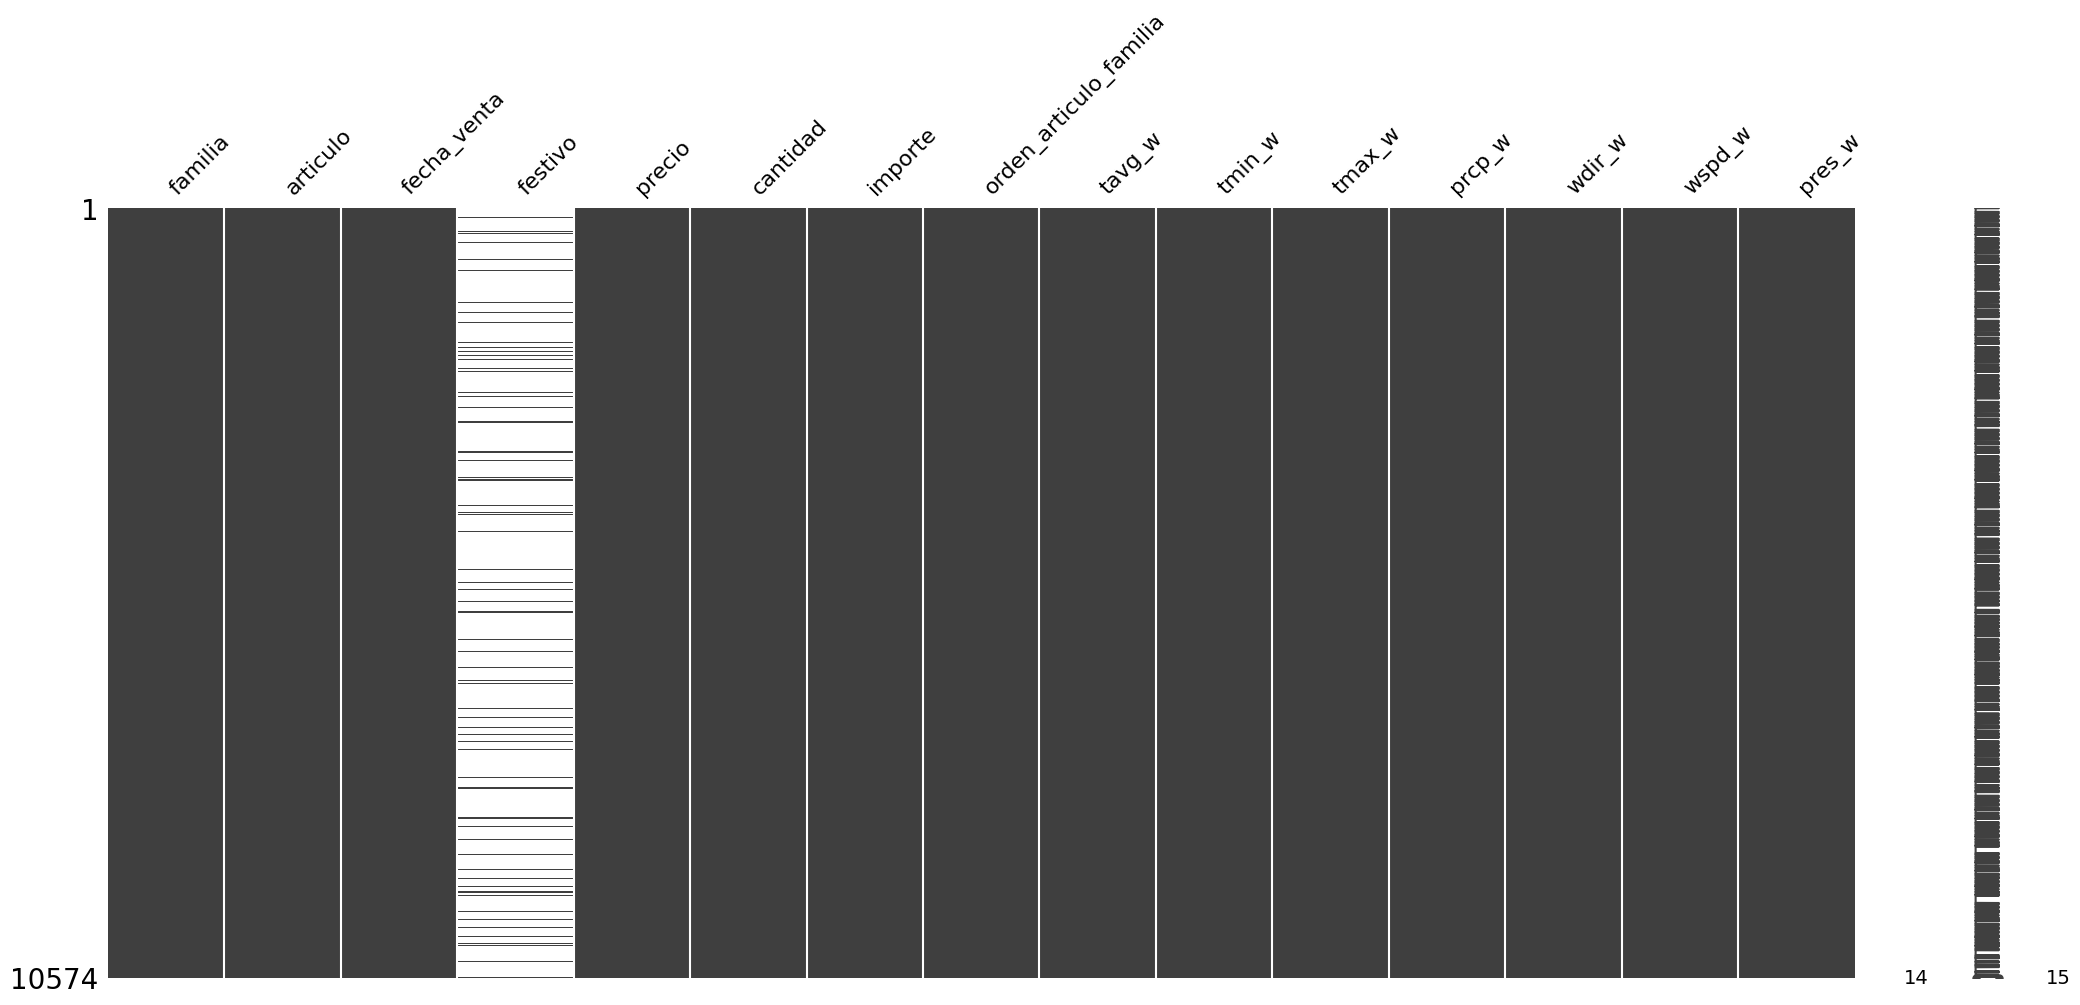

In [12]:
# 3
# Valores nulos

msno.matrix(df)

In [ ]:
# 4
# Valores duplicados

df[df.duplicated(['fecha_venta', 'articulo'], keep=False)]
#df.drop_duplicates(['fecha_venta', 'articulo'])

Empty DataFrame
Columns: [familia, articulo, fecha_venta, festivo, precio, cantidad, importe, orden_articulo_familia, tavg_w, tmin_w, tmax_w, prcp_w, wdir_w, wspd_w, pres_w]
Index: []

**Grupo de preguntas 2** (10 minutos):

5. ¿Cuál es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¿hay fechas faltantes? Crea un gráfico de evolución temporal para la variable "cantidad" que muestre el producto "6549".

6. Separando por producto, ¿hay outliers en la variable "cantidad"?

In [14]:
# 5
# Rango de fechas del conjunto de datos

min_date = df['fecha_venta'].min()
max_date = df['fecha_venta'].max()

print(f"El conjunto de datos contiene valores desde {min_date} hasta {max_date}. ",
      f"Lo que supone {max_date - min_date}")

El conjunto de datos contiene valores desde 2021-05-01 00:00:00 hasta 2023-05-18 00:00:00.  Lo que supone 747 days 00:00:00


In [15]:
# 5
# Fechas faltantes

unique_articles = df.sort_values("familia")["articulo"].unique().tolist()
complete_range = pd.date_range(start=min_date, end=max_date, freq='D')

for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    missing_dates = complete_range.difference(subset['fecha_venta'])

    print(family, "-> Articulo", article, "-> Fechas faltantes", len(missing_dates))

BOLLERIA -> Articulo 3960 -> Fechas faltantes 0
BOLLERIA -> Articulo 5803 -> Fechas faltantes 3
BOLLERIA -> Articulo 3880 -> Fechas faltantes 0
BOLLERIA -> Articulo 6286 -> Fechas faltantes 2
BOLLERIA -> Articulo 6425 -> Fechas faltantes 1
PANADERIA -> Articulo 1084 -> Fechas faltantes 0
PANADERIA -> Articulo 417 -> Fechas faltantes 0
PANADERIA -> Articulo 900 -> Fechas faltantes 0
PANADERIA -> Articulo 968 -> Fechas faltantes 0
PANADERIA -> Articulo 1043 -> Fechas faltantes 0
PASTELERIA -> Articulo 6451 -> Fechas faltantes 74
PASTELERIA -> Articulo 6549 -> Fechas faltantes 312
PASTELERIA -> Articulo 6523 -> Fechas faltantes 49
PASTELERIA -> Articulo 5403 -> Fechas faltantes 107
PASTELERIA -> Articulo 5404 -> Fechas faltantes 98


In [16]:
# 5
# Gráfico de la cantidad del producto "6549"

articulo = 6549
filtered_df = (
    df.query("articulo == @articulo")
      .set_index("fecha_venta")
      .reindex(complete_range)
)

filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')

fig = px.line(filtered_df, x=filtered_df.index, y="cantidad", color="articulo")
fig.show()

In [17]:
articulo = 5403
filtered_df = (
    df.query("articulo == @articulo")
      .set_index("fecha_venta")
      .reindex(complete_range)
)

filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')

fig = px.line(filtered_df, x=filtered_df.index, y="cantidad", color="articulo")
fig.show()

In [18]:
# 6
# Outliers en cantidad desglosando por producto

unique_articles = df.sort_values("familia")["articulo"].unique().tolist()

for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    Q1 = subset['cantidad'].quantile(0.25)
    Q3 = subset['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = subset[(subset['cantidad'] < (Q1 - 1.5 * IQR)) | (subset['cantidad'] > (Q3 + 1.5 * IQR))]

    print(family, "-> Articulo", article, "-> Outliers", len(outliers["cantidad"]))

BOLLERIA -> Articulo 3960 -> Outliers 15
BOLLERIA -> Articulo 5803 -> Outliers 53
BOLLERIA -> Articulo 3880 -> Outliers 36
BOLLERIA -> Articulo 6286 -> Outliers 59
BOLLERIA -> Articulo 6425 -> Outliers 25
PANADERIA -> Articulo 1084 -> Outliers 5
PANADERIA -> Articulo 417 -> Outliers 19
PANADERIA -> Articulo 900 -> Outliers 30
PANADERIA -> Articulo 968 -> Outliers 28
PANADERIA -> Articulo 1043 -> Outliers 36
PASTELERIA -> Articulo 6451 -> Outliers 24
PASTELERIA -> Articulo 6549 -> Outliers 3
PASTELERIA -> Articulo 6523 -> Outliers 36
PASTELERIA -> Articulo 5403 -> Outliers 37
PASTELERIA -> Articulo 5404 -> Outliers 25


In [ ]:
  outliers.head()

familia  articulo fecha_venta          festivo     precio   cantidad  \
2051  PASTELERIA      5404  2021-05-02  Día de la Madre  39.544998  46.710000   
7259  PASTELERIA      5404  2021-05-15             None  39.544998  46.950001   
6622  PASTELERIA      5404  2021-05-22             None  39.544998  53.700000   
6628  PASTELERIA      5404  2021-06-05             None  39.544998  43.650001   
4413  PASTELERIA      5404  2021-06-26             None  39.544998  45.150000   

          importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  prcp_w  \
2051  1847.148033                       1    16.3    10.8    23.2     0.0   
7259  1856.639038                       1    19.4    14.5    24.7     0.0   
6622  2123.570007                       1    23.6    17.4    32.5     0.0   
6628  1726.144005                       1    21.2    19.0    24.3     0.9   
4413  1785.457977                       1    22.8    18.3    28.7     0.0   

      wdir_w  wspd_w  pres_w  
2051   233.0    15.7  1015.9  
7259   112.0    13.9  1016.1  
6622   295.0    19.4  1011.8  
6628   181.0    10.4  1021.1  
4413   140.0    14.7  1016.9

*****

#### 4.2. Análisis de la variable a predecir

Este apartado tiene como cometido comprender la evolución de la variable "cantidad" en el tiempo y como se relaciona esta consigo misma.

**Grupo de preguntas 3** (8 minutos):

7. Crea un gráfico de la evolución temporal general de la variable "cantidad". Nota: Se debe de agrupar.

8. Crea un gráfico de la evolución temporal por familia de la variable "cantidad". Nota: Se debe de agrupar.

9. Crea un gráfico de la evolución temporal por artículo de la variable "cantidad". Nota: Se debe de agrupar.

10. Se que hay mucho ruido, pero ¿a simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

In [20]:
# 7
# Evolución temporal general de la variable "cantidad"

group = df.groupby(pd.Grouper(key="fecha_venta", freq="1D"))["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

In [21]:
# 8
# Evolución temporal por familia de la variable "cantidad"

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")
fig.show()

In [22]:
# 8
# Evolución temporal por familia de la variable "cantidad"

scaler = MinMaxScaler()

def normalize(column):
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
group['cantidad'] = group.groupby('familia')['cantidad'].transform(normalize)
fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")
fig.show()

In [23]:
# 9
# Evolución temporal por artículo de la variable "cantidad"

group = df.groupby(["articulo", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="articulo")
fig.show()

**Grupo de preguntas 4** (15 minutos):

11. Aplica alguna técnica estadística para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". Pista: Tomar la primera diferencia y, después, hacer un analisis de autocorrelación.

12. Sin aplicar la primera diferencia y creando nuevas columnas de fecha a partir de la variable "fecha_venta" (semana del año, mes del año, día de la semana, día del mes, día del año) comprueba realizando diferentes agrupaciones y gráficos si nuestro análisis de autocorrelación de nuestra variable cantidad nos mostraba lo correcto. Si encuentras algún gráfico que te llame la atención, baja el nivel del análisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por artículo).

In [24]:
# 11
# Check si el proceso es estacionario

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

group = df.groupby([pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
check_stationarity(group["cantidad"])
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

ADF Statistic:  -1.4110271943456132
p-value:  0.5769782744361347
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
 Non-stationary 


In [25]:
# 11
# Tomando la primera diferencia

# Podemos tomar la primera diferencia para observar si nuestra serie se convierte en estacionaria.
# Esto elimina tendencias y estabiliza la varianza de la serie, permitiendo que sea modelada.

group["cantidad_diff"] = group["cantidad"].diff().fillna(0)
check_stationarity(group["cantidad_diff"])

ADF Statistic:  -12.581104640506789
p-value:  1.9096088838134613e-23
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
 Stationary 


In [26]:
# 11
# La nueva serie temporal tiene esta pinta

fig = px.line(group, x="fecha_venta", y="cantidad_diff")
fig.show()

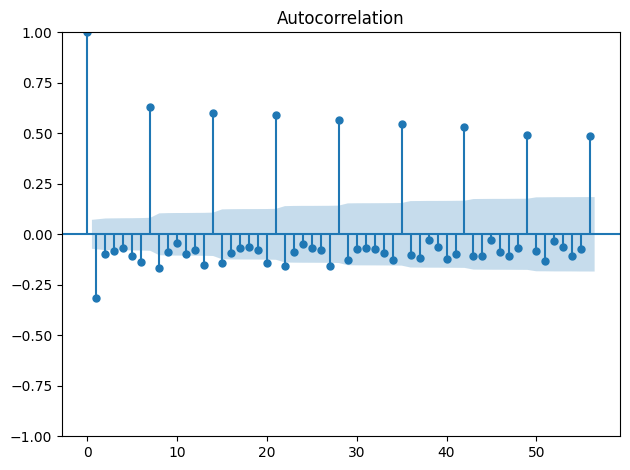

In [27]:
# 11
# Analisis de autocorrelación

# En terminos generales, este gráfico nos indica que un valor de cantidad esta
# directamente relacionado con su valor de cantidad anterior y su valor de cantidad de la semana pasada.
# Parece que hay estacionalidad semanal.

plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

In [28]:
# 12

# Semana y mes del año
df["weekofyear"] = df["fecha_venta"].dt.isocalendar().week
df["monthofyear"] = df["fecha_venta"].dt.month

# Día de la semana, del mes y del año
df["dayofweek"] = df["fecha_venta"].dt.day #Lunes 0 y Domingo 6
df["dayofmonth"] = df["fecha_venta"].dt.month
df["dayofyear"] = df["fecha_venta"].dt.dayofyear

def graph_by_freq(freq, breakdown="familia", norm=False):
    group = df.groupby([breakdown, freq], as_index=False)["cantidad"].sum()

    if norm == True:
        group['cantidad'] = group.groupby(breakdown)['cantidad'].transform(normalize)

    fig = px.line(group, x=freq, y="cantidad", color=breakdown, markers=True)
    fig.show()

# A nivel familia
graph_by_freq("dayofweek")

# Como nos encontramos en nuestro análisis de autocorrelación,
# los valores de cantidad podrían tener una relación con su valor de la semana pasada
# debido a que hay un patrón de compra semanal que se repite en el tiempo.

In [29]:
# 12

# A nivel articulo
graph_by_freq("dayofweek", "articulo")

In [30]:
# 12
# Gráficos caja

fig = px.box(df, x="dayofweek", y="cantidad", color='familia')
fig.show()

In [31]:
graph_by_freq("monthofyear")

*****

#### 4.3. Análisis de la variable a predecir frente al resto de variables

**Grupo de preguntas 5** (8 minutos):

13. ¿El comportamiento de compra (la variable "cantidad") cuando es festivo es superior a cuando no lo es?

14. ¿El comportamiento de compra (la variable "cantidad") cuando llueve es superior a cuando no llueve?

15. Divide la variable "tavg_w" en quintiles y muestra con un gráfico de barras sí la variable "cantidad" es superior en alguno de sus quintiles.

In [32]:
# 13

# 1 si es festivo, 0 si no lo es
df['es_festivo'] = df['festivo'].apply(lambda x: 0 if x is None else 1)

fig = px.box(df, x="es_festivo", y="cantidad", color='familia')
fig.show()

# El comportamiento de compra cuando es festivo parece ligeramente superior

In [33]:
# 14

# 1 si llueve, 0 si no llueve
df["lluvia"] = np.where(df["prcp_w"] > 0, 1, 0)

fig = px.box(df, x="lluvia", y="cantidad", color='familia')
fig.show()

# Parece que la lluvia no es un impedimiento para comprar

In [34]:
# 15

labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

df['quintiles_tavg_w'] = pd.qcut(df['tavg_w'], q=5, labels=labels_tavg)

group = df.groupby(["familia", "quintiles_tavg_w"])["cantidad"].sum().reset_index()
fig = px.bar(group, x='quintiles_tavg_w', y='cantidad', color="familia",barmode='group')
fig.show()

**Grupo de preguntas 6** (8 minutos):

16. ¿Un incremento en el precio reduce la propensión a consumir de un artículo?

In [35]:
# 16

def function_variations(x):
    list_unique = x.unique()
    len_list = len(list_unique)

    if len_list > 1:
        return 1
    else:
        return 0

group = df.groupby(["articulo",
                    pd.Grouper(key="fecha_venta", freq="1M"),
                    "familia"]).agg({"cantidad": "sum",
                                     "precio": function_variations}).reset_index()

group["precio"] = group.groupby("articulo")["precio"].transform("cumsum")
group["precio"] = group["precio"].astype(object)

fig = px.box(group, x="precio", y="cantidad", color='articulo')
fig.show()

# No es concluyente debido a que puede haber una tendencia negativa/positiva en el consumo general del articulo
# a lo largo del tiempo, pero es interesante observar como muchas veces si que tiene un impacto negativo
# (productos: 417, 1043, 1084, 3960, 5403).
# Podría ser también por la canibalización de nuevos productos a otros anteriores.

*****

# Modelado

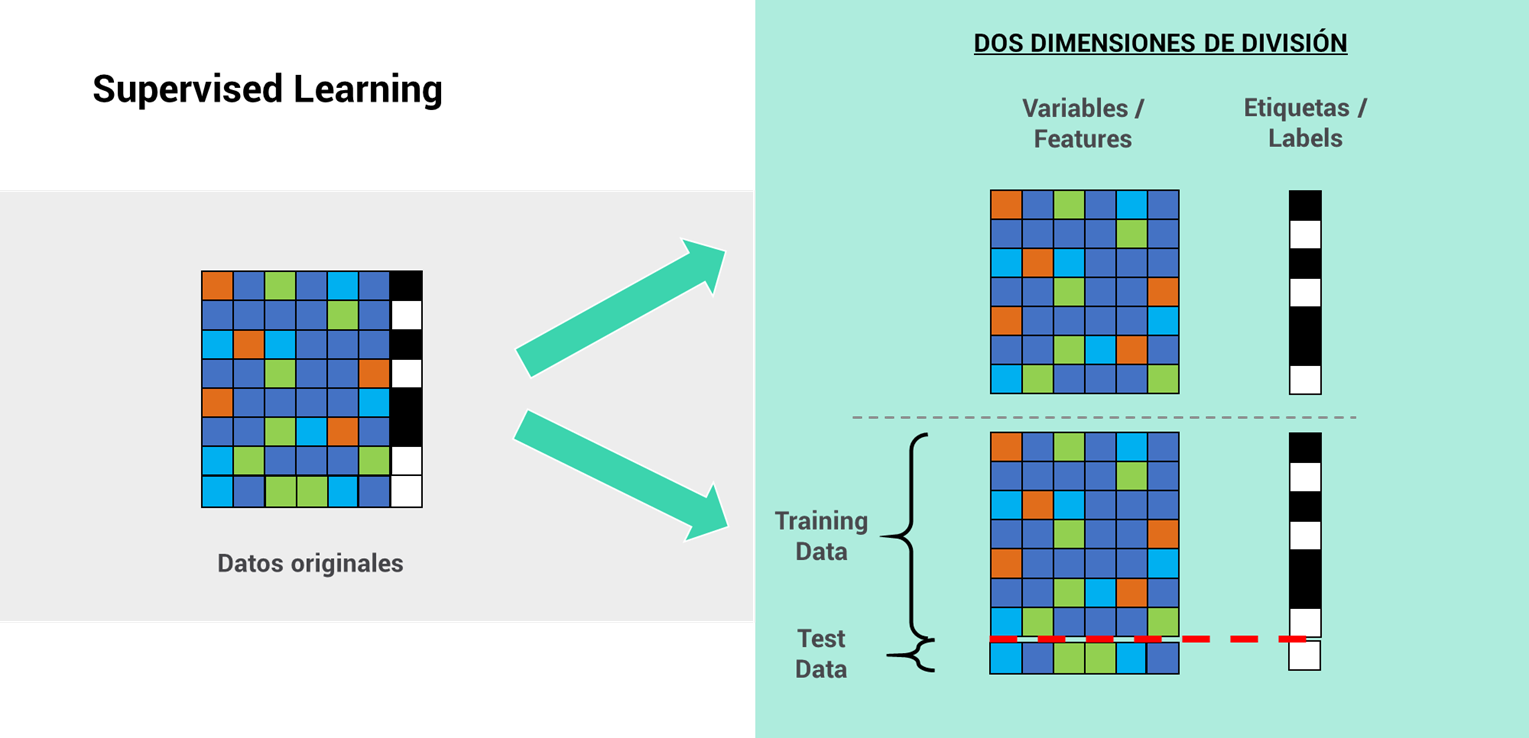

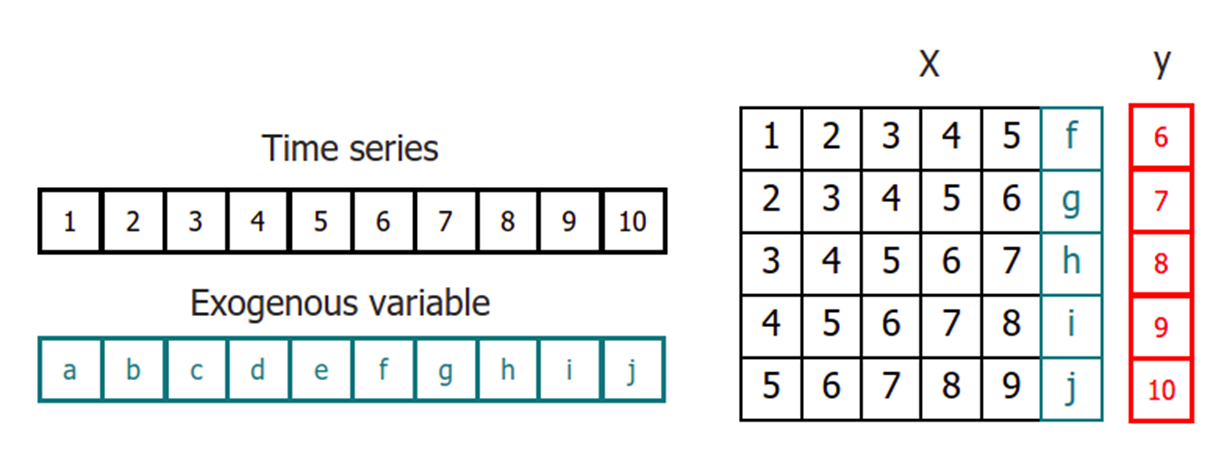

## Preguntas clave en el proceso de creación de un modelo de predicción de series temporales


*   ¿Qué variable quiero predecir?

*   ¿Qué ventana temporal quiero predecir?

*   ¿Cada cuanto se actualiza mi BBDD con datos nuevos?

*   ¿Cuánto tarda mi modelo en entrenar?

*   ¿Qué día influyen más en mi target?

*   ¿Qué patrón se suele repetir?

*   ¿Qué variables exógenas son las que más influyen?


**Etapas**

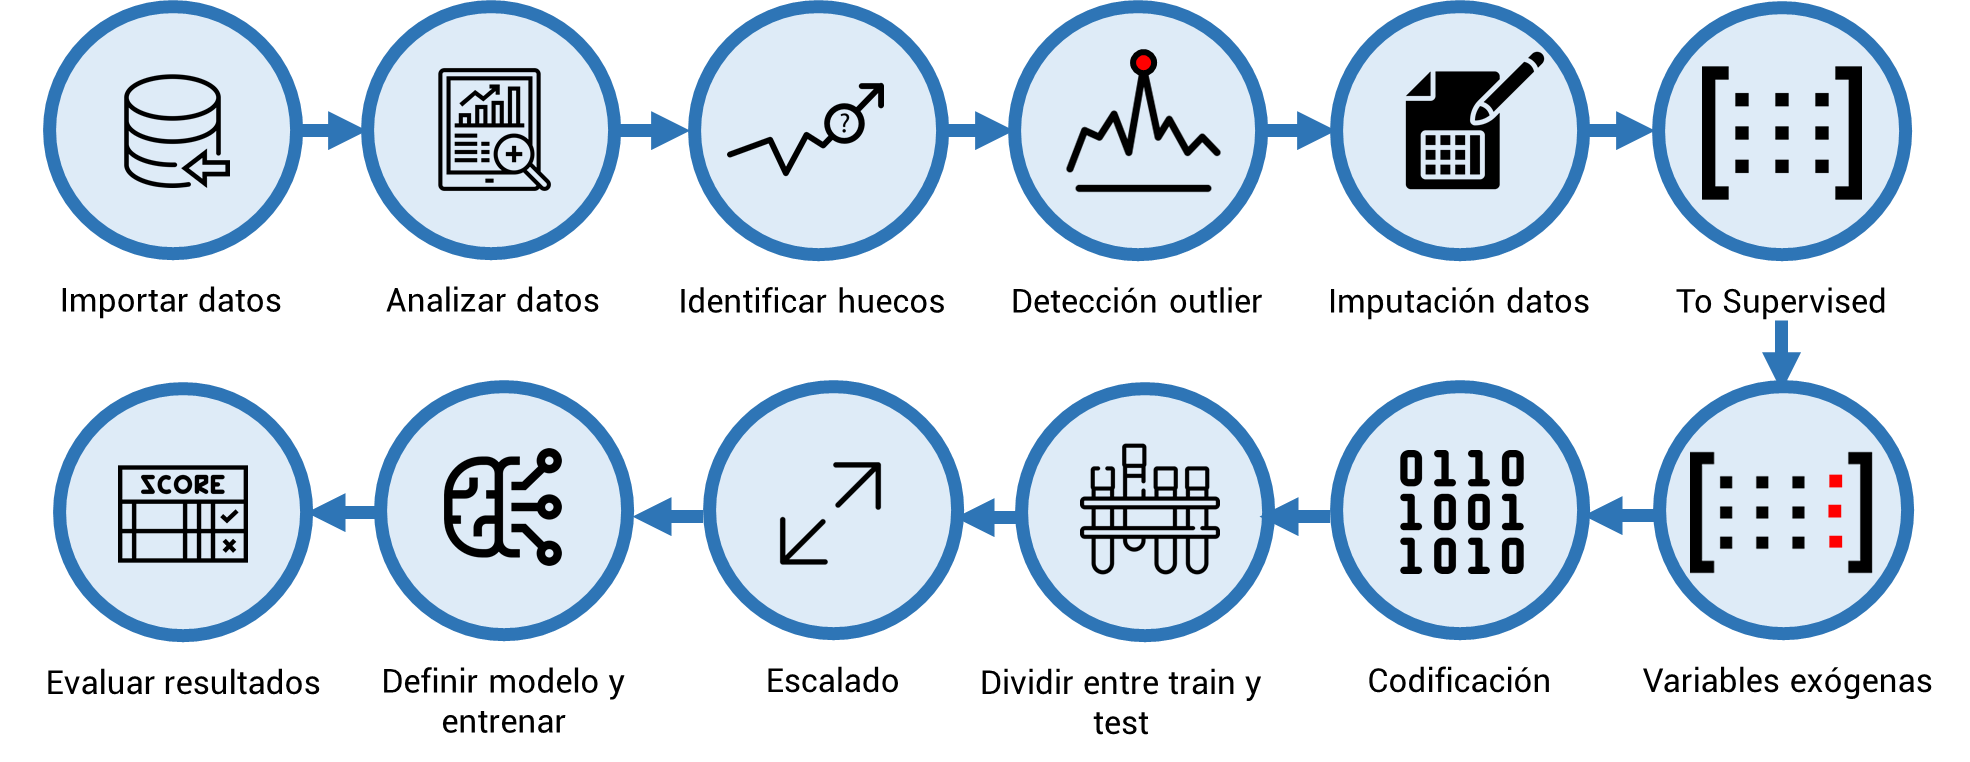

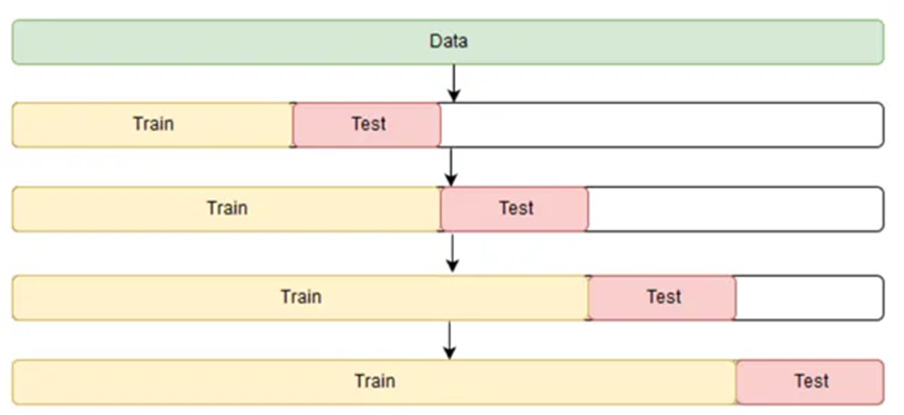

## Análisis inicial

In [36]:
df

familia  articulo fecha_venta          festivo  precio  cantidad  \
8952   PANADERIA       417  2021-05-01             None   4.038      72.0   
2050   PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
9803   PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
2683   PANADERIA       417  2021-05-04             None   4.038      84.0   
8299   PANADERIA       417  2021-05-05             None   4.038      84.0   
...          ...       ...         ...              ...     ...       ...   
8156  PASTELERIA      6549  2023-05-12             None  32.591      15.0   
993   PASTELERIA      6549  2023-05-13             None  32.591      12.0   
8755  PASTELERIA      6549  2023-05-14             None  32.591      12.0   
7576  PASTELERIA      6549  2023-05-15             None  32.591       3.0   
2010  PASTELERIA      6549  2023-05-16             None  32.591       3.0   

         importe  orden_articulo_familia  tavg_w  tmin_w  ...  wspd_w  pres_w  \
8952  290.736004                       5    17.2    11.9  ...    14.2  1014.0   
2050  327.077995                       5    16.3    10.8  ...    15.7  1015.9   
9803  363.419998                       5    15.3    12.7  ...     9.7  1017.7   
2683  339.192001                       5    16.5    12.0  ...    12.1  1018.0   
8299  339.192003                       5    16.7    12.3  ...    13.8  1016.5   
...          ...                     ...     ...     ...  ...     ...     ...   
8156  488.865005                       5    19.4    16.6  ...    13.3  1013.4   
993   391.092010                       5    18.6    15.9  ...    15.9  1016.0   
8755  391.092010                       5    19.4    14.1  ...    12.6  1018.2   
7576   97.773003                       5    23.8    15.9  ...    15.5  1015.5   
2010   97.773003                       5    22.3    17.8  ...    17.6  1013.0   

      weekofyear  monthofyear  dayofweek  dayofmonth  dayofyear  es_festivo  \
8952          17            5          1           5        121           0   
2050          17            5          2           5        122           1   
9803          18            5          3           5        123           1   
2683          18            5          4           5        124           0   
8299          18            5          5           5        125           0   
...          ...          ...        ...         ...        ...         ...   
8156          19            5         12           5        132           0   
993           19            5         13           5        133           0   
8755          19            5         14           5        134           0   
7576          20            5         15           5        135           0   
2010          20            5         16           5        136           0   

      lluvia    quintiles_tavg_w  
8952       0    Temperatura baja  
2050       0    Temperatura baja  
9803       1    Temperatura baja  
2683       0    Temperatura baja  
8299       0    Temperatura baja  
...      ...                 ...  
8156       0  Temperatura normal  
993        0  Temperatura normal  
8755       0  Temperatura normal  
7576       0    Temperatura alta  
2010       0    Temperatura alta  

[10574 rows x 23 columns]

In [37]:
df[["familia", "articulo"]].drop_duplicates().sort_values("familia").reset_index(drop=True)

familia  articulo
0     BOLLERIA      3880
1     BOLLERIA      3960
2     BOLLERIA      5803
3     BOLLERIA      6286
4     BOLLERIA      6425
5    PANADERIA       417
6    PANADERIA       900
7    PANADERIA       968
8    PANADERIA      1043
9    PANADERIA      1084
10  PASTELERIA      5403
11  PASTELERIA      5404
12  PASTELERIA      6451
13  PASTELERIA      6523
14  PASTELERIA      6549

In [38]:
df

familia  articulo fecha_venta          festivo  precio  cantidad  \
8952   PANADERIA       417  2021-05-01             None   4.038      72.0   
2050   PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
9803   PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
2683   PANADERIA       417  2021-05-04             None   4.038      84.0   
8299   PANADERIA       417  2021-05-05             None   4.038      84.0   
...          ...       ...         ...              ...     ...       ...   
8156  PASTELERIA      6549  2023-05-12             None  32.591      15.0   
993   PASTELERIA      6549  2023-05-13             None  32.591      12.0   
8755  PASTELERIA      6549  2023-05-14             None  32.591      12.0   
7576  PASTELERIA      6549  2023-05-15             None  32.591       3.0   
2010  PASTELERIA      6549  2023-05-16             None  32.591       3.0   

         importe  orden_articulo_familia  tavg_w  tmin_w  ...  wspd_w  pres_w  \
8952  290.736004                       5    17.2    11.9  ...    14.2  1014.0   
2050  327.077995                       5    16.3    10.8  ...    15.7  1015.9   
9803  363.419998                       5    15.3    12.7  ...     9.7  1017.7   
2683  339.192001                       5    16.5    12.0  ...    12.1  1018.0   
8299  339.192003                       5    16.7    12.3  ...    13.8  1016.5   
...          ...                     ...     ...     ...  ...     ...     ...   
8156  488.865005                       5    19.4    16.6  ...    13.3  1013.4   
993   391.092010                       5    18.6    15.9  ...    15.9  1016.0   
8755  391.092010                       5    19.4    14.1  ...    12.6  1018.2   
7576   97.773003                       5    23.8    15.9  ...    15.5  1015.5   
2010   97.773003                       5    22.3    17.8  ...    17.6  1013.0   

      weekofyear  monthofyear  dayofweek  dayofmonth  dayofyear  es_festivo  \
8952          17            5          1           5        121           0   
2050          17            5          2           5        122           1   
9803          18            5          3           5        123           1   
2683          18            5          4           5        124           0   
8299          18            5          5           5        125           0   
...          ...          ...        ...         ...        ...         ...   
8156          19            5         12           5        132           0   
993           19            5         13           5        133           0   
8755          19            5         14           5        134           0   
7576          20            5         15           5        135           0   
2010          20            5         16           5        136           0   

      lluvia    quintiles_tavg_w  
8952       0    Temperatura baja  
2050       0    Temperatura baja  
9803       1    Temperatura baja  
2683       0    Temperatura baja  
8299       0    Temperatura baja  
...      ...                 ...  
8156       0  Temperatura normal  
993        0  Temperatura normal  
8755       0  Temperatura normal  
7576       0    Temperatura alta  
2010       0    Temperatura alta  

[10574 rows x 23 columns]

In [39]:
family = "BOLLERIA"
item = 3960

itemdata = df.loc[(df["familia"] == family) & (df["articulo"] == item)].reset_index(drop=True)
itemdata["fecha_venta"] = pd.to_datetime(itemdata["fecha_venta"])
itemdata.sort_values("fecha_venta", ascending=True, inplace=True)
itemdata

familia  articulo fecha_venta          festivo  precio  cantidad  \
0    BOLLERIA      3960  2021-05-01             None   2.318     402.0   
1    BOLLERIA      3960  2021-05-02  Día de la Madre   2.318     369.0   
2    BOLLERIA      3960  2021-05-03   Día de la Cruz   2.318     228.0   
3    BOLLERIA      3960  2021-05-04             None   2.318     237.0   
4    BOLLERIA      3960  2021-05-05             None   2.318     288.0   
..        ...       ...         ...              ...     ...       ...   
743  BOLLERIA      3960  2023-05-14             None   3.273     231.0   
744  BOLLERIA      3960  2023-05-15             None   3.273     174.0   
745  BOLLERIA      3960  2023-05-16             None   3.273     117.0   
746  BOLLERIA      3960  2023-05-17             None   3.273     228.0   
747  BOLLERIA      3960  2023-05-18             None   3.273     186.0   

        importe  orden_articulo_familia  tavg_w  tmin_w  ...  wspd_w  pres_w  \
0    931.835995                       1    17.2    11.9  ...    14.2  1014.0   
1    855.341996                       1    16.3    10.8  ...    15.7  1015.9   
2    528.503994                       1    15.3    12.7  ...     9.7  1017.7   
3    549.365999                       1    16.5    12.0  ...    12.1  1018.0   
4    667.584000                       1    16.7    12.3  ...    13.8  1016.5   
..          ...                     ...     ...     ...  ...     ...     ...   
743  756.063019                       1    19.4    14.1  ...    12.6  1018.2   
744  569.502014                       1    23.8    15.9  ...    15.5  1015.5   
745  382.941010                       1    22.3    17.8  ...    17.6  1013.0   
746  746.244019                       1    19.2    17.2  ...     9.5  1013.4   
747  608.778015                       1    17.0    13.7  ...    14.2  1016.3   

     weekofyear  monthofyear  dayofweek  dayofmonth  dayofyear  es_festivo  \
0            17            5          1           5        121           0   
1            17            5          2           5        122           1   
2            18            5          3           5        123           1   
3            18            5          4           5        124           0   
4            18            5          5           5        125           0   
..          ...          ...        ...         ...        ...         ...   
743          19            5         14           5        134           0   
744          20            5         15           5        135           0   
745          20            5         16           5        136           0   
746          20            5         17           5        137           0   
747          20            5         18           5        138           0   

     lluvia    quintiles_tavg_w  
0         0    Temperatura baja  
1         0    Temperatura baja  
2         1    Temperatura baja  
3         0    Temperatura baja  
4         0    Temperatura baja  
..      ...                 ...  
743       0  Temperatura normal  
744       0    Temperatura alta  
745       0    Temperatura alta  
746       0  Temperatura normal  
747       1    Temperatura baja  

[748 rows x 23 columns]

In [40]:
itemdata["lluvia"] = np.where(itemdata["prcp_w"]>0, 1, 0)
itemdata

familia  articulo fecha_venta          festivo  precio  cantidad  \
0    BOLLERIA      3960  2021-05-01             None   2.318     402.0   
1    BOLLERIA      3960  2021-05-02  Día de la Madre   2.318     369.0   
2    BOLLERIA      3960  2021-05-03   Día de la Cruz   2.318     228.0   
3    BOLLERIA      3960  2021-05-04             None   2.318     237.0   
4    BOLLERIA      3960  2021-05-05             None   2.318     288.0   
..        ...       ...         ...              ...     ...       ...   
743  BOLLERIA      3960  2023-05-14             None   3.273     231.0   
744  BOLLERIA      3960  2023-05-15             None   3.273     174.0   
745  BOLLERIA      3960  2023-05-16             None   3.273     117.0   
746  BOLLERIA      3960  2023-05-17             None   3.273     228.0   
747  BOLLERIA      3960  2023-05-18             None   3.273     186.0   

        importe  orden_articulo_familia  tavg_w  tmin_w  ...  wspd_w  pres_w  \
0    931.835995                       1    17.2    11.9  ...    14.2  1014.0   
1    855.341996                       1    16.3    10.8  ...    15.7  1015.9   
2    528.503994                       1    15.3    12.7  ...     9.7  1017.7   
3    549.365999                       1    16.5    12.0  ...    12.1  1018.0   
4    667.584000                       1    16.7    12.3  ...    13.8  1016.5   
..          ...                     ...     ...     ...  ...     ...     ...   
743  756.063019                       1    19.4    14.1  ...    12.6  1018.2   
744  569.502014                       1    23.8    15.9  ...    15.5  1015.5   
745  382.941010                       1    22.3    17.8  ...    17.6  1013.0   
746  746.244019                       1    19.2    17.2  ...     9.5  1013.4   
747  608.778015                       1    17.0    13.7  ...    14.2  1016.3   

     weekofyear  monthofyear  dayofweek  dayofmonth  dayofyear  es_festivo  \
0            17            5          1           5        121           0   
1            17            5          2           5        122           1   
2            18            5          3           5        123           1   
3            18            5          4           5        124           0   
4            18            5          5           5        125           0   
..          ...          ...        ...         ...        ...         ...   
743          19            5         14           5        134           0   
744          20            5         15           5        135           0   
745          20            5         16           5        136           0   
746          20            5         17           5        137           0   
747          20            5         18           5        138           0   

     lluvia    quintiles_tavg_w  
0         0    Temperatura baja  
1         0    Temperatura baja  
2         1    Temperatura baja  
3         0    Temperatura baja  
4         0    Temperatura baja  
..      ...                 ...  
743       0  Temperatura normal  
744       0    Temperatura alta  
745       0    Temperatura alta  
746       0  Temperatura normal  
747       1    Temperatura baja  

[748 rows x 23 columns]

In [41]:
itemdata["festivo"].unique()

array([None, 'Día de la Madre', 'Día de la Cruz', 'Día de San Juan',
       'Día de la Virgen del Carmen', 'Día de la Victoria',
       'Fiesta de la Virgen de la Victoria',
       'Día de la Hispanidad (Fiesta Nacional de España)',
       'Noche de Halloween', 'Día de Todos los Santos',
       'Día de la Constitución', 'Nochebuena', 'Navidad', 'Nochevieja',
       'Año Nuevo', 'Día de Reyes', 'Día de San Valentín',
       'Día del Padre', 'Domingo de Ramos', 'Lunes Santo', 'Martes Santo',
       'Miércoles Santo', 'Jueves Santo', 'Viernes Santo', 'Sábado Santo',
       'Domingo de Resurrección', 'Feria de Málaga'], dtype=object)

In [42]:
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2022,12,8), "festivo"] = "Día de la Inmaculada"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2021,12,8), "festivo"] = "Día de la Inmaculada"

In [43]:
f = list(itemdata["festivo"].unique())[1:]
itemdata["isfestivo"] = np.where(itemdata["festivo"].isin(f), 1, 0)
itemdata

familia  articulo fecha_venta          festivo  precio  cantidad  \
0    BOLLERIA      3960  2021-05-01             None   2.318     402.0   
1    BOLLERIA      3960  2021-05-02  Día de la Madre   2.318     369.0   
2    BOLLERIA      3960  2021-05-03   Día de la Cruz   2.318     228.0   
3    BOLLERIA      3960  2021-05-04             None   2.318     237.0   
4    BOLLERIA      3960  2021-05-05             None   2.318     288.0   
..        ...       ...         ...              ...     ...       ...   
743  BOLLERIA      3960  2023-05-14             None   3.273     231.0   
744  BOLLERIA      3960  2023-05-15             None   3.273     174.0   
745  BOLLERIA      3960  2023-05-16             None   3.273     117.0   
746  BOLLERIA      3960  2023-05-17             None   3.273     228.0   
747  BOLLERIA      3960  2023-05-18             None   3.273     186.0   

        importe  orden_articulo_familia  tavg_w  tmin_w  ...  pres_w  \
0    931.835995                       1    17.2    11.9  ...  1014.0   
1    855.341996                       1    16.3    10.8  ...  1015.9   
2    528.503994                       1    15.3    12.7  ...  1017.7   
3    549.365999                       1    16.5    12.0  ...  1018.0   
4    667.584000                       1    16.7    12.3  ...  1016.5   
..          ...                     ...     ...     ...  ...     ...   
743  756.063019                       1    19.4    14.1  ...  1018.2   
744  569.502014                       1    23.8    15.9  ...  1015.5   
745  382.941010                       1    22.3    17.8  ...  1013.0   
746  746.244019                       1    19.2    17.2  ...  1013.4   
747  608.778015                       1    17.0    13.7  ...  1016.3   

     weekofyear  monthofyear  dayofweek  dayofmonth  dayofyear  es_festivo  \
0            17            5          1           5        121           0   
1            17            5          2           5        122           1   
2            18            5          3           5        123           1   
3            18            5          4           5        124           0   
4            18            5          5           5        125           0   
..          ...          ...        ...         ...        ...         ...   
743          19            5         14           5        134           0   
744          20            5         15           5        135           0   
745          20            5         16           5        136           0   
746          20            5         17           5        137           0   
747          20            5         18           5        138           0   

     lluvia    quintiles_tavg_w  isfestivo  
0         0    Temperatura baja          0  
1         0    Temperatura baja          1  
2         1    Temperatura baja          1  
3         0    Temperatura baja          0  
4         0    Temperatura baja          0  
..      ...                 ...        ...  
743       0  Temperatura normal          0  
744       0    Temperatura alta          0  
745       0    Temperatura alta          0  
746       0  Temperatura normal          0  
747       1    Temperatura baja          0  

[748 rows x 24 columns]

In [44]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["cantidad"], name="Cantidad vendida"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["wspd_w"], name="Viento"),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="Fecha")

# Set y-axes titles
fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Festivo", secondary_y=True)

fig.show()

In [45]:
itemSales = itemdata.loc[itemdata["fecha_venta"]<datetime.datetime(2023,4,10)]
itemSalesTest = itemdata.loc[itemdata["fecha_venta"]>=datetime.datetime(2023,4,10)]

In [46]:
itemSalesTest

familia  articulo fecha_venta          festivo  precio  cantidad  \
709  BOLLERIA      3960  2023-04-10             None   3.273     213.0   
710  BOLLERIA      3960  2023-04-11             None   3.273     153.0   
711  BOLLERIA      3960  2023-04-12             None   3.273     183.0   
712  BOLLERIA      3960  2023-04-13             None   3.273     138.0   
713  BOLLERIA      3960  2023-04-14             None   3.273     204.0   
714  BOLLERIA      3960  2023-04-15             None   3.273     276.0   
715  BOLLERIA      3960  2023-04-16             None   3.273     333.0   
716  BOLLERIA      3960  2023-04-17             None   3.273     192.0   
717  BOLLERIA      3960  2023-04-18             None   3.273     234.0   
718  BOLLERIA      3960  2023-04-19             None   3.273     183.0   
719  BOLLERIA      3960  2023-04-20             None   3.273     222.0   
720  BOLLERIA      3960  2023-04-21             None   3.273     216.0   
721  BOLLERIA      3960  2023-04-22             None   3.273     297.0   
722  BOLLERIA      3960  2023-04-23             None   3.273     336.0   
723  BOLLERIA      3960  2023-04-24             None   3.273     204.0   
724  BOLLERIA      3960  2023-04-25             None   3.273     246.0   
725  BOLLERIA      3960  2023-04-26             None   3.273     162.0   
726  BOLLERIA      3960  2023-04-27             None   3.273     216.0   
727  BOLLERIA      3960  2023-04-28             None   3.273     183.0   
728  BOLLERIA      3960  2023-04-29             None   3.273     249.0   
729  BOLLERIA      3960  2023-04-30             None   3.273     330.0   
730  BOLLERIA      3960  2023-05-01             None   3.273     396.0   
731  BOLLERIA      3960  2023-05-02             None   3.273     222.0   
732  BOLLERIA      3960  2023-05-03   Día de la Cruz   3.273     186.0   
733  BOLLERIA      3960  2023-05-04             None   3.273     198.0   
734  BOLLERIA      3960  2023-05-05             None   3.273     219.0   
735  BOLLERIA      3960  2023-05-06             None   3.273     285.0   
736  BOLLERIA      3960  2023-05-07  Día de la Madre   3.273     390.0   
737  BOLLERIA      3960  2023-05-08             None   3.273     204.0   
738  BOLLERIA      3960  2023-05-09             None   3.273     168.0   
739  BOLLERIA      3960  2023-05-10             None   3.273     159.0   
740  BOLLERIA      3960  2023-05-11             None   3.273     261.0   
741  BOLLERIA      3960  2023-05-12             None   3.273     210.0   
742  BOLLERIA      3960  2023-05-13             None   3.273     306.0   
743  BOLLERIA      3960  2023-05-14             None   3.273     231.0   
744  BOLLERIA      3960  2023-05-15             None   3.273     174.0   
745  BOLLERIA      3960  2023-05-16             None   3.273     117.0   
746  BOLLERIA      3960  2023-05-17             None   3.273     228.0   
747  BOLLERIA      3960  2023-05-18             None   3.273     186.0   

         importe  orden_articulo_familia  tavg_w  tmin_w  ...  pres_w  \
709   697.149017                       1    22.8    12.7  ...  1020.7   
710   500.769012                       1    17.8    14.6  ...  1020.7   
711   598.959015                       1    22.6    14.5  ...  1015.8   
712   451.674011                       1    20.2    15.4  ...  1016.9   
713   667.692017                       1    21.8    16.1  ...  1017.7   
714   903.348022                       1    22.0    18.1  ...  1017.0   
715  1089.909027                       1    18.8    14.7  ...  1017.0   
716   628.416016                       1    15.8    10.8  ...  1014.8   
717   765.882019                       1    15.7    10.4  ...  1012.3   
718   598.959015                       1    16.3    13.4  ...  1012.8   
719   726.606018                       1    16.3    11.0  ...  1012.3   
720   706.968018                       1    18.2    10.7  ...  1008.4   
721   972.081024                       1    20.8    14.8  ...  1011.6   
722  1099.728027       

## Preprocesado

### Identificación de huecos

In [47]:
itemSales.set_index("fecha_venta", inplace=True)
itemSales

familia  articulo                  festivo  precio  cantidad  \
fecha_venta                                                                  
2021-05-01   BOLLERIA      3960                     None   2.318     402.0   
2021-05-02   BOLLERIA      3960          Día de la Madre   2.318     369.0   
2021-05-03   BOLLERIA      3960           Día de la Cruz   2.318     228.0   
2021-05-04   BOLLERIA      3960                     None   2.318     237.0   
2021-05-05   BOLLERIA      3960                     None   2.318     288.0   
...               ...       ...                      ...     ...       ...   
2023-04-05   BOLLERIA      3960          Miércoles Santo   3.273     231.0   
2023-04-06   BOLLERIA      3960             Jueves Santo   3.273     327.0   
2023-04-07   BOLLERIA      3960            Viernes Santo   3.273     330.0   
2023-04-08   BOLLERIA      3960             Sábado Santo   3.273     267.0   
2023-04-09   BOLLERIA      3960  Domingo de Resurrección   3.273     315.0   

                 importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  ...  \
fecha_venta                                                               ...   
2021-05-01    931.835995                       1    17.2    11.9    22.8  ...   
2021-05-02    855.341996                       1    16.3    10.8    23.2  ...   
2021-05-03    528.503994                       1    15.3    12.7    20.1  ...   
2021-05-04    549.365999                       1    16.5    12.0    20.9  ...   
2021-05-05    667.584000                       1    16.7    12.3    21.7  ...   
...                  ...                     ...     ...     ...     ...  ...   
2023-04-05    756.063019                       1    14.4     9.3    20.3  ...   
2023-04-06   1070.271027                       1    15.4    10.8    21.2  ...   
2023-04-07   1080.090027                       1    13.9     8.5    19.8  ...   
2023-04-08    873.891022                       1    14.1     6.4    21.5  ...   
2023-04-09   1030.995026                       1    14.9     9.3    20.6  ...   

             pres_w  weekofyear  monthofyear  dayofweek  dayofmonth  \
fecha_venta                                                           
2021-05-01   1014.0          17            5          1           5   
2021-05-02   1015.9          17            5          2           5   
2021-05-03   1017.7          18            5          3           5   
2021-05-04   1018.0          18            5          4           5   
2021-05-05   1016.5          18            5          5           5   
...             ...         ...          ...        ...         ...   
2023-04-05   1016.1          14            4          5           4   
2023-04-06   1016.9          14            4          6           4   
2023-04-07   1018.2          14            4          7           4   
2023-04-08   1017.2          14            4          8           4   
2023-04-09   1020.4          14            4          9           4   

             dayofyear  es_festivo  lluvia      quintiles_tavg_w  isfestivo  
fecha_venta                                                                  
2021-05-01         121           0       0      Temperatura baja          0  
2021-05-02         122           1       0      Temperatura baja          1  
2021-05-03         123           1       1      Temperatura baja          1  
2021-05-04         124           0       0      Temperatura baja          0  
2021-05-05         125           0       0      Temperatura baja          0  
...                ...         ...     ...                   ...        ...  
2023-04-05          95           1       0      Temperatura baja          1  
2023-04-06          96           1       0      Temperatura baja          1  
2023-04-07          97           1       0  Temperatura muy baja          1  
2023-04-08          98           1       0      Temperatura baja          1  
2023-04-09          99           1       0      Temperatura baja          1  

[709 r

In [48]:
itemSalesComplete = itemSales.resample("1D").last()
itemSales = itemSalesComplete.copy()
itemSales

familia  articulo                  festivo  precio  cantidad  \
fecha_venta                                                                  
2021-05-01   BOLLERIA      3960                     None   2.318     402.0   
2021-05-02   BOLLERIA      3960          Día de la Madre   2.318     369.0   
2021-05-03   BOLLERIA      3960           Día de la Cruz   2.318     228.0   
2021-05-04   BOLLERIA      3960                     None   2.318     237.0   
2021-05-05   BOLLERIA      3960                     None   2.318     288.0   
...               ...       ...                      ...     ...       ...   
2023-04-05   BOLLERIA      3960          Miércoles Santo   3.273     231.0   
2023-04-06   BOLLERIA      3960             Jueves Santo   3.273     327.0   
2023-04-07   BOLLERIA      3960            Viernes Santo   3.273     330.0   
2023-04-08   BOLLERIA      3960             Sábado Santo   3.273     267.0   
2023-04-09   BOLLERIA      3960  Domingo de Resurrección   3.273     315.0   

                 importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  ...  \
fecha_venta                                                               ...   
2021-05-01    931.835995                       1    17.2    11.9    22.8  ...   
2021-05-02    855.341996                       1    16.3    10.8    23.2  ...   
2021-05-03    528.503994                       1    15.3    12.7    20.1  ...   
2021-05-04    549.365999                       1    16.5    12.0    20.9  ...   
2021-05-05    667.584000                       1    16.7    12.3    21.7  ...   
...                  ...                     ...     ...     ...     ...  ...   
2023-04-05    756.063019                       1    14.4     9.3    20.3  ...   
2023-04-06   1070.271027                       1    15.4    10.8    21.2  ...   
2023-04-07   1080.090027                       1    13.9     8.5    19.8  ...   
2023-04-08    873.891022                       1    14.1     6.4    21.5  ...   
2023-04-09   1030.995026                       1    14.9     9.3    20.6  ...   

             pres_w  weekofyear  monthofyear  dayofweek  dayofmonth  \
fecha_venta                                                           
2021-05-01   1014.0          17            5          1           5   
2021-05-02   1015.9          17            5          2           5   
2021-05-03   1017.7          18            5          3           5   
2021-05-04   1018.0          18            5          4           5   
2021-05-05   1016.5          18            5          5           5   
...             ...         ...          ...        ...         ...   
2023-04-05   1016.1          14            4          5           4   
2023-04-06   1016.9          14            4          6           4   
2023-04-07   1018.2          14            4          7           4   
2023-04-08   1017.2          14            4          8           4   
2023-04-09   1020.4          14            4          9           4   

             dayofyear  es_festivo  lluvia      quintiles_tavg_w  isfestivo  
fecha_venta                                                                  
2021-05-01         121           0       0      Temperatura baja          0  
2021-05-02         122           1       0      Temperatura baja          1  
2021-05-03         123           1       1      Temperatura baja          1  
2021-05-04         124           0       0      Temperatura baja          0  
2021-05-05         125           0       0      Temperatura baja          0  
...                ...         ...     ...                   ...        ...  
2023-04-05          95           1       0      Temperatura baja          1  
2023-04-06          96           1       0      Temperatura baja          1  
2023-04-07          97           1       0  Temperatura muy baja          1  
2023-04-08          98           1       0      Temperatura baja          1  
2023-04-09          99           1       0      Temperatura baja          1  

[709 r

In [49]:
itemSales.head(20)

familia  articulo          festivo  precio  cantidad  \
fecha_venta                                                          
2021-05-01   BOLLERIA      3960             None   2.318     402.0   
2021-05-02   BOLLERIA      3960  Día de la Madre   2.318     369.0   
2021-05-03   BOLLERIA      3960   Día de la Cruz   2.318     228.0   
2021-05-04   BOLLERIA      3960             None   2.318     237.0   
2021-05-05   BOLLERIA      3960             None   2.318     288.0   
2021-05-06   BOLLERIA      3960             None   2.318     144.0   
2021-05-07   BOLLERIA      3960             None   2.318     252.0   
2021-05-08   BOLLERIA      3960             None   2.318     276.0   
2021-05-09   BOLLERIA      3960             None   2.318     345.0   
2021-05-10   BOLLERIA      3960             None   2.318     174.0   
2021-05-11   BOLLERIA      3960             None   2.318     174.0   
2021-05-12   BOLLERIA      3960             None   2.318     180.0   
2021-05-13   BOLLERIA      3960             None   2.318     228.0   
2021-05-14   BOLLERIA      3960             None   2.318     216.0   
2021-05-15   BOLLERIA      3960             None   2.318     216.0   
2021-05-16   BOLLERIA      3960             None   2.318     324.0   
2021-05-17   BOLLERIA      3960             None   2.318     177.0   
2021-05-18   BOLLERIA      3960             None   2.318     216.0   
2021-05-19   BOLLERIA      3960             None   2.318     162.0   
2021-05-20   BOLLERIA      3960             None   2.318     177.0   

                importe  orden_articulo_familia  tavg_w  tmin_w  tmax_w  ...  \
fecha_venta                                                              ...   
2021-05-01   931.835995                       1    17.2    11.9    22.8  ...   
2021-05-02   855.341996                       1    16.3    10.8    23.2  ...   
2021-05-03   528.503994                       1    15.3    12.7    20.1  ...   
2021-05-04   549.365999                       1    16.5    12.0    20.9  ...   
2021-05-05   667.584000                       1    16.7    12.3    21.7  ...   
2021-05-06   333.792000                       1    17.9    12.7    23.6  ...   
2021-05-07   584.136007                       1    18.4    14.4    22.4  ...   
2021-05-08   639.768007                       1    20.4    13.9    26.0  ...   
2021-05-09   799.709997                       1    19.4    15.9    24.1  ...   
2021-05-10   403.332010                       1    17.3    13.3    22.3  ...   
2021-05-11   403.331997                       1    18.6    13.5    25.0  ...   
2021-05-12   417.239997                       1    21.9    16.4    29.4  ...   
2021-05-13   528.504005                       1    23.1    17.4    30.5  ...   
2021-05-14   500.688006                       1    23.3    17.7    31.6  ...   
2021-05-15   500.688008                       1    19.4    14.5    24.7  ...   
2021-05-16   751.032001                       1    27.3    22.1    35.6  ...   
2021-05-17   410.285996                       1    24.1    18.9    31.3  ...   
2021-05-18   500.688008                       1    19.8    18.0    23.4  ...   
2021-05-19   375.515999                       1    21.2    19.0    25.8  ...   
2021-05-20   410.286000                       1    19.3    16.7    23.3  ...   

             pres_w  weekofyear  monthofyear  dayofweek  dayofmonth  \
fecha_venta                                                           
2021-05-01   1014.0          17            5          1           5   
2021-05-02   1015.9          17            5          2           5   
2021-05-03   1017.7          18            5          3           5   
2021-05-04   1018.0          18            5          4           5   
2021-05-05   1016.5          18            5          5           5   
2021-05-06   1017.2          18            5          6           5   
2021-05-07   1017.5          18            5          7           5   
2021-05-08   1015.0          18            5          8           5   
20

### Convertir el problema a supervisado

In [50]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in_daily=1, n_in_weekly=1, n_out=1, dropnan=True):
    """
    Adapta un problema de series temporales a aprendizaje supervisado.
    Arguments:
      data: secuencia de observaciones como numpy array
      n_in_daily: ancho de la ventana (nº de observaciones) como input (X).
      n_out: ancho de la ventana (nº de observaciones) como output (y).
      dropnan: booleano para indicar si elimino los NaN o no
    Returns:
      Pandas DataFrame de la series para aprendizaje supervisado.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # input sequence sales for days (t-n, ... t-1)
    for i in range(n_in_daily, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d day)' % (j+1, i)) for j in range(n_vars)]
    # input sequence sales for weeks (t-n, ... t-1)
    for i in range(n_in_weekly, 0, -1):
      cols.append(df.shift(i*7))
      names += [('var%d(t-%d week)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Se junta todo
    agg = concat(cols, axis=1)
    agg.columns = names
    # Eliminación de NaN
    if dropnan:
      agg.dropna(inplace=True)

    return agg

In [51]:
itemSalesSupervised = series_to_supervised(pd.DataFrame(itemSales["cantidad"]), n_in_daily = 5, n_in_weekly = 2, n_out = 1)
itemSalesSupervised

var1(t-5 day)  var1(t-4 day)  var1(t-3 day)  var1(t-2 day)  \
fecha_venta                                                               
2021-05-15           174.0          174.0          180.0          228.0   
2021-05-16           174.0          180.0          228.0          216.0   
2021-05-17           180.0          228.0          216.0          216.0   
2021-05-18           228.0          216.0          216.0          324.0   
2021-05-19           216.0          216.0          324.0          177.0   
...                    ...            ...            ...            ...   
2023-04-05           216.0          210.0          315.0          210.0   
2023-04-06           210.0          315.0          210.0          204.0   
2023-04-07           315.0          210.0          204.0          231.0   
2023-04-08           210.0          204.0          231.0          327.0   
2023-04-09           204.0          231.0          327.0          330.0   

             var1(t-1 day)  var1(t-2 week)  var1(t-1 week)  var1(t)  
fecha_venta                                                          
2021-05-15           216.0           402.0           276.0    216.0  
2021-05-16           216.0           369.0           345.0    324.0  
2021-05-17           324.0           228.0           174.0    177.0  
2021-05-18           177.0           237.0           174.0    216.0  
2021-05-19           216.0           288.0           180.0    162.0  
...                    ...             ...             ...      ...  
2023-04-05           204.0           216.0           207.0    231.0  
2023-04-06           231.0           270.0           192.0    327.0  
2023-04-07           327.0           150.0           216.0    330.0  
2023-04-08           330.0           309.0           210.0    267.0  
2023-04-09           267.0           321.0           315.0    315.0  

[695 rows x 8 columns]

In [52]:
itemSalesSupervised.reset_index(inplace=True)
itemSales.reset_index(inplace=True)

### Variables exógenas

In [53]:
itemSales

fecha_venta   familia  articulo                  festivo  precio  \
0    2021-05-01  BOLLERIA      3960                     None   2.318   
1    2021-05-02  BOLLERIA      3960          Día de la Madre   2.318   
2    2021-05-03  BOLLERIA      3960           Día de la Cruz   2.318   
3    2021-05-04  BOLLERIA      3960                     None   2.318   
4    2021-05-05  BOLLERIA      3960                     None   2.318   
..          ...       ...       ...                      ...     ...   
704  2023-04-05  BOLLERIA      3960          Miércoles Santo   3.273   
705  2023-04-06  BOLLERIA      3960             Jueves Santo   3.273   
706  2023-04-07  BOLLERIA      3960            Viernes Santo   3.273   
707  2023-04-08  BOLLERIA      3960             Sábado Santo   3.273   
708  2023-04-09  BOLLERIA      3960  Domingo de Resurrección   3.273   

     cantidad      importe  orden_articulo_familia  tavg_w  tmin_w  ...  \
0       402.0   931.835995                       1    17.2    11.9  ...   
1       369.0   855.341996                       1    16.3    10.8  ...   
2       228.0   528.503994                       1    15.3    12.7  ...   
3       237.0   549.365999                       1    16.5    12.0  ...   
4       288.0   667.584000                       1    16.7    12.3  ...   
..        ...          ...                     ...     ...     ...  ...   
704     231.0   756.063019                       1    14.4     9.3  ...   
705     327.0  1070.271027                       1    15.4    10.8  ...   
706     330.0  1080.090027                       1    13.9     8.5  ...   
707     267.0   873.891022                       1    14.1     6.4  ...   
708     315.0  1030.995026                       1    14.9     9.3  ...   

     pres_w  weekofyear  monthofyear  dayofweek  dayofmonth  dayofyear  \
0    1014.0          17            5          1           5        121   
1    1015.9          17            5          2           5        122   
2    1017.7          18            5          3           5        123   
3    1018.0          18            5          4           5        124   
4    1016.5          18            5          5           5        125   
..      ...         ...          ...        ...         ...        ...   
704  1016.1          14            4          5           4         95   
705  1016.9          14            4          6           4         96   
706  1018.2          14            4          7           4         97   
707  1017.2          14            4          8           4         98   
708  1020.4          14            4          9           4         99   

     es_festivo  lluvia      quintiles_tavg_w  isfestivo  
0             0       0      Temperatura baja          0  
1             1       0      Temperatura baja          1  
2             1       1      Temperatura baja          1  
3             0       0      Temperatura baja          0  
4             0       0      Temperatura baja          0  
..          ...     ...                   ...        ...  
704           1       0      Temperatura baja          1  
705           1       0      Temperatura baja          1  
706           1       0  Temperatura muy baja          1  
707           1       0      Temperatura baja          1  
708           1       0      Temperatura baja          1  

[709 rows x 24 columns]

In [54]:
vars = ["fecha_venta", "tavg_w", "isfestivo", "lluvia"]
itemSalesSupervised = itemSalesSupervised.merge(itemSales[vars], on="fecha_venta", how="inner")
itemSalesSupervised

fecha_venta  var1(t-5 day)  var1(t-4 day)  var1(t-3 day)  var1(t-2 day)  \
0    2021-05-15          174.0          174.0          180.0          228.0   
1    2021-05-16          174.0          180.0          228.0          216.0   
2    2021-05-17          180.0          228.0          216.0          216.0   
3    2021-05-18          228.0          216.0          216.0          324.0   
4    2021-05-19          216.0          216.0          324.0          177.0   
..          ...            ...            ...            ...            ...   
690  2023-04-05          216.0          210.0          315.0          210.0   
691  2023-04-06          210.0          315.0          210.0          204.0   
692  2023-04-07          315.0          210.0          204.0          231.0   
693  2023-04-08          210.0          204.0          231.0          327.0   
694  2023-04-09          204.0          231.0          327.0          330.0   

     var1(t-1 day)  var1(t-2 week)  var1(t-1 week)  var1(t)  tavg_w  \
0            216.0           402.0           276.0    216.0    19.4   
1            216.0           369.0           345.0    324.0    27.3   
2            324.0           228.0           174.0    177.0    24.1   
3            177.0           237.0           174.0    216.0    19.8   
4            216.0           288.0           180.0    162.0    21.2   
..             ...             ...             ...      ...     ...   
690          204.0           216.0           207.0    231.0    14.4   
691          231.0           270.0           192.0    327.0    15.4   
692          327.0           150.0           216.0    330.0    13.9   
693          330.0           309.0           210.0    267.0    14.1   
694          267.0           321.0           315.0    315.0    14.9   

     isfestivo  lluvia  
0            0       0  
1            0       0  
2            0       0  
3            0       0  
4            0       1  
..         ...     ...  
690          1       0  
691          1       0  
692          1       0  
693          1       0  
694          1       0  

[695 rows x 12 columns]

In [55]:
itemSalesSupervised["day"] = itemSalesSupervised["fecha_venta"].dt.day
itemSalesSupervised["month"] = itemSalesSupervised["fecha_venta"].dt.month
itemSalesSupervised["year"] = itemSalesSupervised["fecha_venta"].dt.year
itemSalesSupervised["dayofweek"] = itemSalesSupervised["fecha_venta"].dt.dayofweek + 1
itemSalesSupervised["weekday"] = itemSalesSupervised["dayofweek"]<6
itemSalesSupervised

fecha_venta  var1(t-5 day)  var1(t-4 day)  var1(t-3 day)  var1(t-2 day)  \
0    2021-05-15          174.0          174.0          180.0          228.0   
1    2021-05-16          174.0          180.0          228.0          216.0   
2    2021-05-17          180.0          228.0          216.0          216.0   
3    2021-05-18          228.0          216.0          216.0          324.0   
4    2021-05-19          216.0          216.0          324.0          177.0   
..          ...            ...            ...            ...            ...   
690  2023-04-05          216.0          210.0          315.0          210.0   
691  2023-04-06          210.0          315.0          210.0          204.0   
692  2023-04-07          315.0          210.0          204.0          231.0   
693  2023-04-08          210.0          204.0          231.0          327.0   
694  2023-04-09          204.0          231.0          327.0          330.0   

     var1(t-1 day)  var1(t-2 week)  var1(t-1 week)  var1(t)  tavg_w  \
0            216.0           402.0           276.0    216.0    19.4   
1            216.0           369.0           345.0    324.0    27.3   
2            324.0           228.0           174.0    177.0    24.1   
3            177.0           237.0           174.0    216.0    19.8   
4            216.0           288.0           180.0    162.0    21.2   
..             ...             ...             ...      ...     ...   
690          204.0           216.0           207.0    231.0    14.4   
691          231.0           270.0           192.0    327.0    15.4   
692          327.0           150.0           216.0    330.0    13.9   
693          330.0           309.0           210.0    267.0    14.1   
694          267.0           321.0           315.0    315.0    14.9   

     isfestivo  lluvia  day  month  year  dayofweek  weekday  
0            0       0   15      5  2021          6    False  
1            0       0   16      5  2021          7    False  
2            0       0   17      5  2021          1     True  
3            0       0   18      5  2021          2     True  
4            0       1   19      5  2021          3     True  
..         ...     ...  ...    ...   ...        ...      ...  
690          1       0    5      4  2023          3     True  
691          1       0    6      4  2023          4     True  
692          1       0    7      4  2023          5     True  
693          1       0    8      4  2023          6    False  
694          1       0    9      4  2023          7    False  

[695 rows x 17 columns]

### Codificación

In [56]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
itemSalesSupervised["weekday"] = lb.fit_transform(itemSalesSupervised["weekday"])
itemSalesSupervised

fecha_venta  var1(t-5 day)  var1(t-4 day)  var1(t-3 day)  var1(t-2 day)  \
0    2021-05-15          174.0          174.0          180.0          228.0   
1    2021-05-16          174.0          180.0          228.0          216.0   
2    2021-05-17          180.0          228.0          216.0          216.0   
3    2021-05-18          228.0          216.0          216.0          324.0   
4    2021-05-19          216.0          216.0          324.0          177.0   
..          ...            ...            ...            ...            ...   
690  2023-04-05          216.0          210.0          315.0          210.0   
691  2023-04-06          210.0          315.0          210.0          204.0   
692  2023-04-07          315.0          210.0          204.0          231.0   
693  2023-04-08          210.0          204.0          231.0          327.0   
694  2023-04-09          204.0          231.0          327.0          330.0   

     var1(t-1 day)  var1(t-2 week)  var1(t-1 week)  var1(t)  tavg_w  \
0            216.0           402.0           276.0    216.0    19.4   
1            216.0           369.0           345.0    324.0    27.3   
2            324.0           228.0           174.0    177.0    24.1   
3            177.0           237.0           174.0    216.0    19.8   
4            216.0           288.0           180.0    162.0    21.2   
..             ...             ...             ...      ...     ...   
690          204.0           216.0           207.0    231.0    14.4   
691          231.0           270.0           192.0    327.0    15.4   
692          327.0           150.0           216.0    330.0    13.9   
693          330.0           309.0           210.0    267.0    14.1   
694          267.0           321.0           315.0    315.0    14.9   

     isfestivo  lluvia  day  month  year  dayofweek  weekday  
0            0       0   15      5  2021          6        0  
1            0       0   16      5  2021          7        0  
2            0       0   17      5  2021          1        1  
3            0       0   18      5  2021          2        1  
4            0       1   19      5  2021          3        1  
..         ...     ...  ...    ...   ...        ...      ...  
690          1       0    5      4  2023          3        1  
691          1       0    6      4  2023          4        1  
692          1       0    7      4  2023          5        1  
693          1       0    8      4  2023          6        0  
694          1       0    9      4  2023          7        0  

[695 rows x 17 columns]

## Modelado

In [57]:
def plottingResults(comparison):

    comparison['diff'] = comparison["yreal"] - comparison["ypred"]
    fig, ax = plt.subplots(figsize=(10,8))
    comparison["diff"].hist(bins=10, ax=ax)
    ax.set_xticklabels(ax.get_xticks(),fontsize=8)
    ax.set_yticklabels(ax.get_yticks(),fontsize=8)
    ax.set_xlabel("Error", fontname='Serif', fontsize=8)
    ax.set_title("Histograma del error de predicción", fontname='Serif', fontsize=8)

In [58]:
def plottingSeries(comparison, check = True):

    #### Plotting evolution
    if check:
      comparisonplot = comparison.rename({"yreal":"Venta real", "ypred": "Venta predicha ML"}, axis=1)
      fig = px.line(comparisonplot, x="fecha", y=["Venta real", "Venta predicha ML"])
      fig.show()
    else:
      comparisonplot = comparison.rename({"cantidad":"Venta predicha tienda", "yreal":"Venta real", "ypred": "Venta predicha ML"}, axis=1)
      fig = px.line(comparisonplot, x="fecha", y=["Venta real", "Venta predicha ML", "Venta predicha tienda"])
      fig.show()

In [59]:
def plottingComparison(comparison):

    i=0
    comparison["line"] = [i+j*(comparison["yreal"].max()+20)/len(comparison) for j in range(len(comparison))]
    comparison["line2"] = comparison["line"]

    fig, ax = plt.subplots(figsize=(10,8))
    comparison.plot(x="line", y="line2", ax=ax, color="red", marker="*", markersize=2)
    comparison.plot.scatter(x="yreal", y="ypred", ax=ax, color="blue")
    ax.grid(True)
    ax.set_yticklabels(ax.get_yticks(minor=False), fontname='Serif', fontsize=8)
    ax.set_xticklabels(ax.get_xticks(minor=False), fontname='Serif', fontsize=8)
    ax.set_ylabel("Ventas predichas", fontname='Serif', fontsize=8)
    ax.set_xlabel("Ventas reales", fontname='Serif', fontsize=8)
    ax.set_title("Ventas reales VS Ventas predichas", fontname='Serif', fontsize=8)
    ax.get_legend().remove()

In [60]:
from sklearn.preprocessing import MinMaxScaler

def tsscale(df):
  dfScaled = df.copy()
  colstoscaled = df.columns[1:]
  newcols = []
  for i in colstoscaled:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(np.array(df[i]).reshape(-1,1)) #Reshape: Lo convierte a columna
    j = i+"_scaled"
    newcols.append(j)
    dfScaled[j] = scaler.transform(np.array(df[i]).reshape(-1,1))
    if i == "var1(t)":  # Nos quedamos con el scaler de la variable dependiente para desescalar las predicciones y analizarlo
      scalerToUnscale = scaler
  return dfScaled, scalerToUnscale

In [61]:
itemSalesSupervised

fecha_venta  var1(t-5 day)  var1(t-4 day)  var1(t-3 day)  var1(t-2 day)  \
0    2021-05-15          174.0          174.0          180.0          228.0   
1    2021-05-16          174.0          180.0          228.0          216.0   
2    2021-05-17          180.0          228.0          216.0          216.0   
3    2021-05-18          228.0          216.0          216.0          324.0   
4    2021-05-19          216.0          216.0          324.0          177.0   
..          ...            ...            ...            ...            ...   
690  2023-04-05          216.0          210.0          315.0          210.0   
691  2023-04-06          210.0          315.0          210.0          204.0   
692  2023-04-07          315.0          210.0          204.0          231.0   
693  2023-04-08          210.0          204.0          231.0          327.0   
694  2023-04-09          204.0          231.0          327.0          330.0   

     var1(t-1 day)  var1(t-2 week)  var1(t-1 week)  var1(t)  tavg_w  \
0            216.0           402.0           276.0    216.0    19.4   
1            216.0           369.0           345.0    324.0    27.3   
2            324.0           228.0           174.0    177.0    24.1   
3            177.0           237.0           174.0    216.0    19.8   
4            216.0           288.0           180.0    162.0    21.2   
..             ...             ...             ...      ...     ...   
690          204.0           216.0           207.0    231.0    14.4   
691          231.0           270.0           192.0    327.0    15.4   
692          327.0           150.0           216.0    330.0    13.9   
693          330.0           309.0           210.0    267.0    14.1   
694          267.0           321.0           315.0    315.0    14.9   

     isfestivo  lluvia  day  month  year  dayofweek  weekday  
0            0       0   15      5  2021          6        0  
1            0       0   16      5  2021          7        0  
2            0       0   17      5  2021          1        1  
3            0       0   18      5  2021          2        1  
4            0       1   19      5  2021          3        1  
..         ...     ...  ...    ...   ...        ...      ...  
690          1       0    5      4  2023          3        1  
691          1       0    6      4  2023          4        1  
692          1       0    7      4  2023          5        1  
693          1       0    8      4  2023          6        0  
694          1       0    9      4  2023          7        0  

[695 rows x 17 columns]

In [62]:
datatrain = itemSalesSupervised.loc[0:670, :]
datatest = itemSalesSupervised.loc[671:, :]
testdates = datatest["fecha_venta"].to_list()

In [63]:
datatrain

fecha_venta  var1(t-5 day)  var1(t-4 day)  var1(t-3 day)  var1(t-2 day)  \
0    2021-05-15          174.0          174.0          180.0          228.0   
1    2021-05-16          174.0          180.0          228.0          216.0   
2    2021-05-17          180.0          228.0          216.0          216.0   
3    2021-05-18          228.0          216.0          216.0          324.0   
4    2021-05-19          216.0          216.0          324.0          177.0   
..          ...            ...            ...            ...            ...   
666  2023-03-12          168.0          183.0          177.0          255.0   
667  2023-03-13          183.0          177.0          255.0          312.0   
668  2023-03-14          177.0          255.0          312.0          276.0   
669  2023-03-15          255.0          312.0          276.0          150.0   
670  2023-03-16          312.0          276.0          150.0          219.0   

     var1(t-1 day)  var1(t-2 week)  var1(t-1 week)  var1(t)  tavg_w  \
0            216.0           402.0           276.0    216.0    19.4   
1            216.0           369.0           345.0    324.0    27.3   
2            324.0           228.0           174.0    177.0    24.1   
3            177.0           237.0           174.0    216.0    19.8   
4            216.0           288.0           180.0    162.0    21.2   
..             ...             ...             ...      ...     ...   
666          312.0           507.0           429.0    276.0    19.2   
667          276.0           294.0           201.0    150.0    18.4   
668          150.0           486.0           168.0    219.0    18.7   
669          219.0           171.0           183.0    192.0    15.2   
670          192.0           258.0           177.0    255.0    14.6   

     isfestivo  lluvia  day  month  year  dayofweek  weekday  
0            0       0   15      5  2021          6        0  
1            0       0   16      5  2021          7        0  
2            0       0   17      5  2021          1        1  
3            0       0   18      5  2021          2        1  
4            0       1   19      5  2021          3        1  
..         ...     ...  ...    ...   ...        ...      ...  
666          0       0   12      3  2023          7        0  
667          0       0   13      3  2023          1        1  
668          0       0   14      3  2023          2        1  
669          0       0   15      3  2023          3        1  
670          0       0   16      3  2023          4        1  

[671 rows x 17 columns]

In [64]:
datatest

fecha_venta  var1(t-5 day)  var1(t-4 day)  var1(t-3 day)  var1(t-2 day)  \
671  2023-03-17          276.0          150.0          219.0          192.0   
672  2023-03-18          150.0          219.0          192.0          255.0   
673  2023-03-19          219.0          192.0          255.0          177.0   
674  2023-03-20          192.0          255.0          177.0          327.0   
675  2023-03-21          255.0          177.0          327.0          369.0   
676  2023-03-22          177.0          327.0          369.0          153.0   
677  2023-03-23          327.0          369.0          153.0          216.0   
678  2023-03-24          369.0          153.0          216.0          216.0   
679  2023-03-25          153.0          216.0          216.0          270.0   
680  2023-03-26          216.0          216.0          270.0          150.0   
681  2023-03-27          216.0          270.0          150.0          309.0   
682  2023-03-28          270.0          150.0          309.0          321.0   
683  2023-03-29          150.0          309.0          321.0          183.0   
684  2023-03-30          309.0          321.0          183.0          156.0   
685  2023-03-31          321.0          183.0          156.0          207.0   
686  2023-04-01          183.0          156.0          207.0          192.0   
687  2023-04-02          156.0          207.0          192.0          216.0   
688  2023-04-03          207.0          192.0          216.0          210.0   
689  2023-04-04          192.0          216.0          210.0          315.0   
690  2023-04-05          216.0          210.0          315.0          210.0   
691  2023-04-06          210.0          315.0          210.0          204.0   
692  2023-04-07          315.0          210.0          204.0          231.0   
693  2023-04-08          210.0          204.0          231.0          327.0   
694  2023-04-09          204.0          231.0          327.0          330.0   

     var1(t-1 day)  var1(t-2 week)  var1(t-1 week)  var1(t)  tavg_w  \
671          255.0           273.0           255.0    177.0    16.2   
672          177.0           303.0           312.0    327.0    17.6   
673          327.0           429.0           276.0    369.0    17.6   
674          369.0           201.0           150.0    153.0    13.6   
675          153.0           168.0           219.0    216.0    13.2   
676          216.0           183.0           192.0    216.0    13.7   
677          216.0           177.0           255.0    270.0    14.8   
678          270.0           255.0           177.0    150.0    19.4   
679          150.0           312.0           327.0    309.0    18.9   
680          309.0           276.0           369.0    321.0    21.9   
681          321.0           150.0           153.0    183.0    18.9   
682          183.0           219.0           216.0    156.0    14.6   
683          156.0           192.0           216.0    207.0    15.1   
684          207.0           255.0           270.0    192.0    19.4   
685          192.0           177.0           150.0    216.0    24.2   
686          216.0           327.0           309.0    210.0    22.2   
687          210.0           369.0           321.0    315.0    18.5   
688          315.0           153.0           183.0    210.0    15.7   
689          210.0           216.0           156.0    204.0    14.9   
690          204.0           216.0           207.0    231.0    14.4   
691          231.0           270.0           192.0    327.0    15.4   
692          327.0           150.0           216.0    330.0    13.9   
693          330.0           309.0           210.0    267.0    14.1   
694          267.0           321.0           315.0    315.0    14.9   

     isfestivo  lluvia  day  month  year  dayofweek  weekday  
671          0       0   17      3  2023          5        1  
672          0       0   18      3  2023          6        0  
673          1       0   19      3  2023          7        0  


In [65]:
datatrainscaled, trainunscaler = tsscale(datatrain)
datatestscaled, testunscaler = tsscale(datatest)

In [66]:
datatrainscaled.columns

Index(['fecha_venta', 'var1(t-5 day)', 'var1(t-4 day)', 'var1(t-3 day)',
       'var1(t-2 day)', 'var1(t-1 day)', 'var1(t-2 week)', 'var1(t-1 week)',
       'var1(t)', 'tavg_w', 'isfestivo', 'lluvia', 'day', 'month', 'year',
       'dayofweek', 'weekday', 'var1(t-5 day)_scaled', 'var1(t-4 day)_scaled',
       'var1(t-3 day)_scaled', 'var1(t-2 day)_scaled', 'var1(t-1 day)_scaled',
       'var1(t-2 week)_scaled', 'var1(t-1 week)_scaled', 'var1(t)_scaled',
       'tavg_w_scaled', 'isfestivo_scaled', 'lluvia_scaled', 'day_scaled',
       'month_scaled', 'year_scaled', 'dayofweek_scaled', 'weekday_scaled'],
      dtype='object')

In [67]:
varcols = ['var1(t-5 day)_scaled', 'var1(t-4 day)_scaled',
       'var1(t-3 day)_scaled', 'var1(t-2 day)_scaled', 'var1(t-1 day)_scaled',
       'var1(t-2 week)_scaled', 'var1(t-1 week)_scaled',
       'tavg_w_scaled', 'isfestivo_scaled', 'lluvia_scaled', 'day_scaled',
       'month_scaled', 'year_scaled', 'dayofweek_scaled', 'weekday_scaled']
label = 'var1(t)_scaled'

X_train = np.array(datatrainscaled[varcols])
y_train = np.array(datatrainscaled[label])
X_test = np.array(datatestscaled[varcols])
y_test = np.array(datatestscaled[label])

In [68]:
X_train

array([[0.13888889, 0.13888889, 0.15277778, ..., 0.        , 0.83333333,
        0.        ],
       [0.13888889, 0.15277778, 0.26388889, ..., 0.        , 1.        ,
        0.        ],
       [0.15277778, 0.26388889, 0.23611111, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.14583333, 0.32638889, 0.45833333, ..., 1.        , 0.16666667,
        1.        ],
       [0.32638889, 0.45833333, 0.375     , ..., 1.        , 0.33333333,
        1.        ],
       [0.45833333, 0.375     , 0.08333333, ..., 1.        , 0.5       ,
        1.        ]])

In [69]:
# Entrenamiento de los modelos
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = GradientBoostingRegressor(learning_rate=0.1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_predunsc = testunscaler.inverse_transform(y_pred.reshape(-1,1))
y_testunsc = testunscaler.inverse_transform(y_test.reshape(-1,1))

y_predunsc = y_predunsc.flatten().astype(int)
y_testunsc = y_testunsc.flatten().astype(int)

comparison = pd.DataFrame({'yreal': y_testunsc, 'ypred': y_predunsc})
comparison["fecha"] = testdates

# Screen print metrics
print("Métricas predicción - real")
print("--MSE")
print(mean_squared_error(comparison["yreal"].to_list(),comparison["ypred"].to_list()))
print("--MAE")
print(mean_absolute_error(comparison["yreal"].to_list(),comparison["ypred"].to_list()))
print("--Error acumulado")
print(sum(abs(np.array(comparison["yreal"].to_list())-np.array(comparison["ypred"].to_list()))))


Métricas predicción - real
--MSE
2470.0416666666665
--MAE
39.791666666666664
--Error acumulado
955


In [70]:
plottingSeries(comparison)

In [71]:
X_test

array([[0.57534247, 0.        , 0.31506849, 0.19178082, 0.47945205,
        0.44086022, 0.47945205, 0.27272727, 0.        , 0.        ,
        0.53333333, 0.        , 0.        , 0.66666667, 1.        ],
       [0.        , 0.31506849, 0.19178082, 0.47945205, 0.12328767,
        0.5483871 , 0.73972603, 0.4       , 0.        , 0.        ,
        0.56666667, 0.        , 0.        , 0.83333333, 0.        ],
       [0.31506849, 0.19178082, 0.47945205, 0.12328767, 0.80821918,
        1.        , 0.57534247, 0.4       , 1.        , 0.        ,
        0.6       , 0.        , 0.        , 1.        , 0.        ],
       [0.19178082, 0.47945205, 0.12328767, 0.80821918, 1.        ,
        0.1827957 , 0.        , 0.03636364, 0.        , 0.        ,
        0.63333333, 0.        , 0.        , 0.        , 1.        ],
       [0.47945205, 0.12328767, 0.80821918, 1.        , 0.01369863,
        0.06451613, 0.31506849, 0.        , 0.        , 0.        ,
        0.66666667, 0.        , 0.        , 